Saving cure_the_princess_test.csv to cure_the_princess_test.csv
Saving cure_the_princess_train.csv to cure_the_princess_train.csv
Saving cure_the_princess_validation.csv to cure_the_princess_validation.csv
Epoch 1, Train Loss: 0.5637, Val Loss: 0.4528
Epoch 2, Train Loss: 0.3993, Val Loss: 0.3049
Epoch 3, Train Loss: 0.3238, Val Loss: 0.2526
Epoch 4, Train Loss: 0.3057, Val Loss: 0.2247
Epoch 5, Train Loss: 0.2444, Val Loss: 0.2460
Epoch 6, Train Loss: 0.2347, Val Loss: 0.1982
Epoch 7, Train Loss: 0.2279, Val Loss: 0.2006
Epoch 8, Train Loss: 0.1994, Val Loss: 0.2114
Epoch 9, Train Loss: 0.2005, Val Loss: 0.9343
Epoch 10, Train Loss: 0.1848, Val Loss: 0.2274
Epoch 11, Train Loss: 0.1713, Val Loss: 0.1871
Epoch 12, Train Loss: 0.1659, Val Loss: 0.1876
Epoch 13, Train Loss: 0.1534, Val Loss: 0.1577
Epoch 14, Train Loss: 0.1448, Val Loss: 0.2388
Epoch 15, Train Loss: 0.1492, Val Loss: 0.2856
Epoch 16, Train Loss: 0.1384, Val Loss: 0.1679
Epoch 17, Train Loss: 0.1308, Val Loss: 0.1866
Epoc

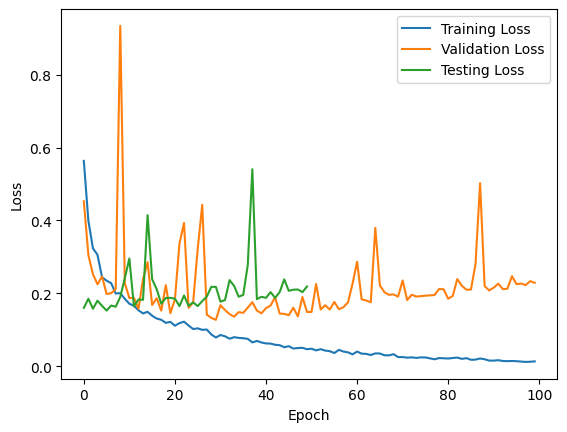

Test Accuracy: 0.4650
Test F1 Score: 0.6165
Test Precision: 0.4819
Test Recall: 0.8557
Execution time CPU: 6.35 seconds


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Set seed
torch.manual_seed(170401085)

# create empty lists to store the training, validation, and test losses
train_losses = []
val_losses = []
test_losses = []
# Upload the train and validation datasets
uploaded = files.upload()

# Read the train and validation datasets into Pandas DataFrames
train_df = pd.read_csv('cure_the_princess_train.csv')
val_df = pd.read_csv('cure_the_princess_validation.csv')
test_df=pd.read_csv('cure_the_princess_test.csv')

# Extract the features and labels from the train and validation DataFrames
train_data = train_df.drop(['Cured'], axis=1).to_numpy()
train_labels = train_df['Cured'].to_numpy().reshape(-1, 1).astype(float)
val_data = val_df.drop(['Cured'], axis=1).to_numpy()
val_labels = val_df['Cured'].to_numpy().reshape(-1, 1).astype(float)
test_data = test_df.drop(['Cured'], axis=1).to_numpy()
test_labels = test_df['Cured'].to_numpy().reshape(-1, 1).astype(float)

# Convert the NumPy arrays to PyTorch Tensors
train_data = torch.from_numpy(train_data).float()
train_labels = torch.from_numpy(train_labels).float()
val_data = torch.from_numpy(val_data).float()
val_labels = torch.from_numpy(val_labels).float()
test_data = torch.from_numpy(test_data).float()
test_labels = torch.from_numpy(test_labels).float()

# Create the training and validation datasets and test data
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)

# Create the training and validation dataloaders and test data 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)


# Define the model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(13, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

model = MLP()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train and validation loops
train_losses = []
val_losses = []

num_epochs = 50

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    # Train
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")



def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def val_epoch(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    return avg_loss



# loop through the dataset for each epoch and compute the training and validation losses
for epoch in range(50):

    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss = val_epoch(model, val_loader, criterion)

    # add the training and validation losses to their respective lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # compute the testing loss and add it to the test loss list
    test_loss = val_epoch(model, test_loader, criterion)
    test_losses.append(test_loss)

    # print the training and validation loss for each epoch
    print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, Test Loss: {test_loss:.3f}')

# plot the training, validation, and test losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Define the model and load the best state dict obtained through early stopping
model = MLP()
# best_model_path = 'best_model.pth'
# model.load_state_dict(torch.load(best_model_path))

# Define a function to calculate evaluation metrics
def evaluate(model, dataloader):
    model.eval()
    with torch.no_grad():
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        true_negatives = 0
        for inputs, labels in dataloader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            true_positives += ((predicted == 1) & (labels == 1)).sum().item()
            false_positives += ((predicted == 1) & (labels == 0)).sum().item()
            false_negatives += ((predicted == 0) & (labels == 1)).sum().item()
            true_negatives += ((predicted == 0) & (labels == 0)).sum().item()
    
    accuracy = (true_positives + true_negatives) / (true_positives + false_positives + false_negatives + true_negatives)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return accuracy, f1, precision, recall

# Calculate evaluation metrics on the test set
test_accuracy, test_f1, test_precision, test_recall = evaluate(model, test_loader)

# Print the evaluation metrics
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')



 

# check if GPU is available

learning_rate = 0.001

# move model and data to GPU device
model.to(device)
train_loader.dataset.tensors = tuple(t.to(device) for t in train_loader.dataset.tensors)
val_loader.dataset.tensors = tuple(t.to(device) for t in val_loader.dataset.tensors)


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss = val_epoch(model, val_loader, criterion)

end_time = time.time()

print(f"Execution time CPU: {end_time - start_time:.2f} seconds")


# New Section